### __Visualizing Type(s) of Weather Events with SVC__

Creates, maps and analyzes weather event data using KMeans Clustering and Support Vector Classifiers.

First Section: creates the map clusters and splits them by a support vector classifier<br>
Second Section: finds the amount of data in each cluster, and computes the closest color name<br>
Third Section: evaluates the algorithm's SVC accuracy<br>

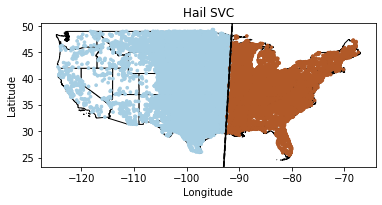

In [28]:
import pandas as pd
import numpy as np
import geopandas as gpd
import webcolors
from matplotlib import colors, pyplot as plt
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# event type to analyze, make in list format - options are:
    #['Flash Flood' 'Thunderstorm Wind' 'Tornado' 'Hail' 'Flood'
    # 'Lightning' 'Heavy Rain' 'Funnel Cloud' 'Debris Flow' 'Marine Thunderstorm Wind'
    # 'Waterspout' 'Dust Devil' 'Marine High Wind' 'Marine Hail' 'Marine Strong Wind']
analyze = ['Hail']
# what percentage should be used for testing in the train/test split
test_percentage = 0.2
# what type of kernel the SVC should use - must be: ‘linear’, ‘poly’, or ‘rbf’
# if poly, change the variable to the desired polynomial degree, or leave as none for the svc to choose
# if not poly, deg variable is ignored
user_kernel = 'linear'
deg = None
# the folder to place the output files
#subfolder = 'SVC Visuals' # for writing to file

# preparing and cleaning data
# import data
col_lst = ["STATE", "EVENT_TYPE", "BEGIN_LAT", "BEGIN_LON", "END_LAT", "END_LON"] # columns to read in
df = pd.read_csv("Data/StormEvents_details-ftp_v1.0_d2019_c20200416.csv", usecols=col_lst)
df = pd.concat([df, pd.read_csv("Data/StormEvents_details-ftp_v1.0_d2018_c20200317.csv", usecols=col_lst)])
df = pd.concat([df, pd.read_csv("Data/StormEvents_details-ftp_v1.0_d2017_c20200121.csv", usecols=col_lst)])
df = pd.concat([df, pd.read_csv("Data/StormEvents_details-ftp_v1.0_d2016_c20190817.csv", usecols=col_lst)])
df = pd.concat([df, pd.read_csv("Data/StormEvents_details-ftp_v1.0_d2015_c20191116.csv", usecols=col_lst)])

# restrict dataframe to a specific event type(s)
dfs=[]
for event in analyze:
    dfs.append(df[df.EVENT_TYPE == event])
df = pd.concat(dfs) # comment out this line to see all events

# remove outside the continental US
df = df.drop(df[(df.STATE == 'HAWAII') | (df.STATE == 'ALASKA') |
                (df.STATE == 'E PACIFIC') | (df.STATE == 'ATLANTIC NORTH') |
                (df.STATE == 'ATLANTIC SOUTH') | (df.STATE == 'GULF OF MEXICO') |
                (df.STATE == 'HAWAII WATERS') | (df.STATE == 'PUERTO RICO') |
                (df.STATE == 'VIRGIN ISLANDS') | (df.STATE == 'AMERICAN SAMOA')].index)
# remove any rows with missing data, then reset the index
df = df.dropna().reset_index(drop=True)

# calculate event mid point
df["MID_LAT"] = (df["BEGIN_LAT"]+df["END_LAT"]) / 2
df["MID_LON"] = (df["BEGIN_LON"]+df["END_LON"]) / 2
df = df.drop(columns=["BEGIN_LAT","END_LAT","BEGIN_LON","END_LON"])


# create a geodataframe from the dataframe's lat and lon
gdf = gpd.GeoDataFrame(df, geometry = gpd.points_from_xy(df.MID_LON,df.MID_LAT))

# load in the map
usa = gpd.read_file('usmap/cb_2018_us_state_500k.shp')
# remove any shapes outside the lower 48 for the map
usa = usa.drop(usa[(usa.STUSPS == 'AK') | (usa.STUSPS == 'HI') | (usa.STUSPS == 'AS') |
                   (usa.STUSPS == 'VI') | (usa.STUSPS == 'MP') | (usa.STUSPS == 'PR') | (usa.STUSPS == 'GU')].index)
# draw outline
ax = usa.plot(color='white', edgecolor='black')
limx, limy = plt.xlim(), plt.ylim() # get current axis

# create the support vector classifier
X = gdf[['MID_LON','MID_LAT']]
clusters = KMeans(n_clusters = 2).fit(X)
gdf['LABEL'] = y = clusters.labels_

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage, random_state=42)
if deg:
    svc = SVC(kernel=user_kernel, degree=deg, gamma='auto').fit(X_train, y_train) # degree gets ignored if kernel != 'poly'
else:
    svc = SVC(kernel=user_kernel, gamma='auto').fit(X_train, y_train) # for when kernel == 'poly' and deg == None

# create the hyperplane(s)
if (user_kernel != 'linear'):
    margin = .3
else:
    margin = 1 / np.sqrt(np.sum(svc.coef_ **2)) # the .coef_ is only applicable/possible with a linear kernel
XX, YY = np.mgrid[limx[0]:limx[1]:200j, limy[0]:limy[1]:200j]
Z = svc.decision_function(np.c_[XX.ravel(), YY.ravel()]).reshape(XX.shape)
plt.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],levels=[-margin, 0, margin])


# image details
plt.ylim(limy)
plt.xlim(limx)
norm = colors.Normalize(vmin=0, vmax=gdf['LABEL'].max())
gdf.plot(ax=ax, markersize=7, c=plt.cm.Paired(norm(gdf['LABEL'].to_numpy())))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(" & ".join(analyze)+' SVC')

# filename and image quality
#plt.savefig(subfolder+"/"+" & ".join(analyze).lower()+"_map", dpi = 350) # for writing to file
plt.show;

In [29]:
# see how many samples are in each cluster
unique_elements, counts_elements = np.unique(gdf['LABEL'], return_counts=True)
freq = pd.DataFrame(data = counts_elements, columns=['Samples'])
freq.index.name = 'Section'

# finds the mathematically closest color name to the given hex
def closest_color(req_color):
    min_color = {}
    for hex_name, name in webcolors.CSS3_HEX_TO_NAMES.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(hex_name)
        rd = (r_c-req_color[0]) ** 2
        gd = (g_c-req_color[1]) ** 2
        bd = (b_c-req_color[2]) ** 2
        min_color[rd+gd+bd] = name
    return min_color[min(min_color.keys())]

# adds colors to the dataframe
norm = colors.Normalize(vmin=0, vmax=len(freq))
clst = []
for i in range(len(freq)):
    clst.append(plt.cm.Paired(norm(i)))
    clst[i] = closest_color(tuple(255*x for x in clst[i][:3]))
freq['Color'] = clst

# move the csv to a separate file
#freq.to_csv(subfolder+"/"+" & ".join(analyze).lower()+"_freq") # for writing to file
print(freq)

         Samples       Color
Section                     
0          32167   lightblue
1          13879  sandybrown


In [30]:
# cross validation score doesn't convert to a string, hence it can't be used when file writing
score = np.mean(cross_val_score(svc, X_test,y_test,scoring="accuracy",cv=5))
strlst.append("Cross Validation Score:",score+"\n")

strlst = []
strlst.append("Train/Test Split: "+str(1-test_percentage)+"\n")
strlst.append("Kernel: "+str(user_kernel)+"\n")
if (user_kernel == 'poly'):
    strlst.append("Polynomial Degree: "+str(deg)+"\n")

y_pred = svc.predict(X_test)
#y_pred = cross_val_predict(svc, X_test,y_test, cv=5)

strlst.append("Confusion Matrix:\n"+str(confusion_matrix(y_test, y_pred))+"\n")
strlst.append("Precision: "+str(precision_score(y_test, y_pred, average="macro"))+"\n")
strlst.append("Recall: "+str(recall_score(y_test, y_pred, average="macro"))+"\n")
strlst.append("F1 Score: "+str(f1_score(y_test, y_pred, average="macro"))+"\n")
print(strlst)

# for writing to file
#with open(subfolder+"/"+" & ".join(analyze).lower()+"_scoring", "w") as file:
#    for line in strlst:
#        file.write(line)

['Train/Test Split: 0.8\n', 'Kernel: linear\n', 'Confusion Matrix:\n[[6445    0]\n [   0 2765]]\n', 'Precision: 1.0\n', 'Recall: 1.0\n', 'F1 Score: 1.0\n']
